In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import torchtext
import re
import time
import matplotlib.pyplot as plt

## 1) Retrieveing and formatting data.

In [2]:
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

In [20]:
train_df = pd.read_csv('data/train.csv')
train_df['text'] = train_df['Title'] + ' ' + train_df['Description']
train_df.drop(columns=['Title', 'Description'], inplace=True)
train_df.rename(columns={'Class Index': 'label'}, inplace=True)
train_df['label'] = train_df['label'].apply(lambda x: x-1)

In [21]:
train_df.head()

,label,text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


## 2) Cleaning text data.

In [22]:
#TODO Describe each and every regex pattern and operation. Also state how long did it take to finalize the 
# text cleaning.
def clean_text(text):
    pattern = re.compile(r'\b[a-zA-Z]+\b')
    output = ' '.join(pattern.findall(text)).lower()
    output = re.sub(r'\b[a-z]\b', '', output)
    output = re.sub(r'\s+', ' ', output).strip()
    return output

In [24]:
clean_df = pd.DataFrame({
    'label': train_df['label'],
    'clean_text': train_df['text'].apply(clean_text)
})


In [25]:
clean_df.head()

,label,clean_text
0,2,wall st bears claw back into the black reuters...
1,2,carlyle looks toward commercial aerospace reut...
2,2,oil and economy cloud stocks outlook reuters r...
3,2,iraq halts oil exports from main southern pipe...
4,2,oil prices soar to all time record posing new ...


#### Store the cleaned data, before preprocessing it.

In [26]:
clean_df.to_pickle('clean_corpus.pkl')

## 3) Preprocessing the text data.
#### Using Stemming and/or Lemmatization.

In [27]:
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import concurrent.futures
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mannpurohit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mannpurohit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
def preprocess_text(text):
    stemmer = LancasterStemmer()
#     lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pp_list = []
    for word in words:
        if word not in stopwords.words('english'):
            pp_list.append(stemmer.stem(word))
#             pp_list.append(lemmatizer.lemmatize(word))
            
    
    pp_text = ' '.join(pp_list)
    return pp_text

In [29]:
import multiprocessing

n_parallel = multiprocessing.cpu_count() # Number of parallel processes
data_range = int(clean_df.shape[0] / n_parallel)
def parallel_pp_text(index):
    start = index*data_range
    end = (index+1)*data_range-1
    pp_text_df = clean_df.loc[start:end, 'clean_text'].apply(preprocess_text)
    
    return pp_text_df

In [30]:
t1 = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(parallel_pp_text, range(n_parallel))
    
    pp_txt_srs = pd.Series()
    for result in results:
        pp_txt_srs = pd.concat((pp_txt_srs, pd.Series(result)))
print(time.perf_counter() - t1)

clean_df['pp_text'] = pp_txt_srs

/opt/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


94.03529770900059


In [31]:
clean_df.to_pickle('preprocessed_data.pkl')

## 4) Retrieving and transforming the test data

In [32]:
test_df = pd.read_csv('data/test.csv')
test_df.rename(columns={'Class Index': 'label'}, inplace=True)
test_df['label'] = test_df['label'].apply(lambda x: x-1)

test_df['text'] = test_df['Title'] + ' ' + test_df['Description']
test_df.drop(columns=['Title', 'Description'], inplace=True)
test_df['clean_text'] = test_df['text'].apply(clean_text)
test_df['pp_text'] = test_df['clean_text'].apply(preprocess_text)
test_df.drop(columns=['text', 'clean_text'], inplace=True)

## 5) Converting text data into numeric vectors

### 5.1) Using TF-IDF

In [39]:
train_df = clean_df.copy()

In [40]:
x_train, x_test = {}, {}
y_train = clean_df['label']
y_test = test_df['label']

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, min_df=5)
tfidf.fit(train_df['pp_text'])

X_names = tfidf.get_feature_names()
tfidf_vectorizer = TfidfVectorizer(vocabulary=X_names)
tfidf_vectorizer.fit(train_df['pp_text'])

TfidfVectorizer(vocabulary=['aa', 'aapl', 'aaron', 'ab', 'abab', 'abandon',
                            'abba', 'abbey', 'abbot', 'abc', 'abd', 'abduc',
                            'abdullah', 'aberdeen', 'abid', 'abids', 'abimael',
                            'abkhaz', 'abl', 'ablaz', 'abn', 'aboard',
                            'aborigin', 'abort', 'abound', 'abraham',
                            'abramovich', 'abroad', 'abrupt', 'abs', ...])

In [42]:
x_train['tfidf'] = tfidf_vectorizer.transform(train_df['pp_text']).toarray()
x_test['tfidf'] = tfidf_vectorizer.transform(test_df['pp_text']).toarray()

### 5.2) Using Tokenizer

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
vocab_size = 10000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size)

In [45]:
tokenizer.fit_on_texts(train_df['pp_text'])

x_train['tokenizer'] = tokenizer.texts_to_sequences(train_df['pp_text'])
x_test['tokenizer'] = tokenizer.texts_to_sequences(test_df['pp_text'])

x_train['tokenizer'] = pad_sequences(x_train['tokenizer'], maxlen=100)
x_test['tokenizer'] = pad_sequences(x_test['tokenizer'], maxlen=100)

## 6) Building Machine Learning Models using sklearn

### 6.1) Multinomial Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [47]:
mnb = {}
mnb_scores = {}

In [48]:
mnb['tfidf'] = MultinomialNB().fit(x_train['tfidf'], y_train)
mnb['tokenizer'] = MultinomialNB().fit(x_train['tokenizer'], y_train)

In [49]:
mnb_scores['tfidf_test'] = mnb['tfidf'].score(x_test['tfidf'], y_test)
mnb_scores['tokenizer_test'] = mnb['tokenizer'].score(x_test['tokenizer'], y_test)

mnb_scores['tfidf_train'] = mnb['tfidf'].score(x_train['tfidf'], y_train)
mnb_scores['tokenizer_train'] = mnb['tokenizer'].score(x_train['tokenizer'], y_train)

In [50]:
mnb_scores

{'tfidf_test': 0.8972368421052631,
 'tokenizer_test': 0.30236842105263156,
 'tfidf_train': 0.9072083333333333,
 'tokenizer_train': 0.301275}

In [51]:
param_grid = {'alpha': [0.01, 0.1, 1]}
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5)

In [52]:
grid.fit(x_train['tfidf'], y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1]})

In [53]:
best_mnb = grid.best_estimator_

In [224]:
# grid.cv_results_

{'mean_fit_time': array([19.18047714, 18.64394817, 18.44900465]),
 'std_fit_time': array([0.54710253, 0.1590319 , 0.22088995]),
 'mean_score_time': array([1.26183667, 1.07919483, 1.10490685]),
 'std_score_time': array([0.14646254, 0.07338719, 0.07767165]),
 'param_alpha': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
 'split0_test_score': array([0.87233333, 0.87520833, 0.87754167]),
 'split1_test_score': array([0.8895  , 0.8925  , 0.893375]),
 'split2_test_score': array([0.89029167, 0.892375  , 0.89225   ]),
 'split3_test_score': array([0.90533333, 0.907875  , 0.90875   ]),
 'split4_test_score': array([0.88970833, 0.89183333, 0.89133333]),
 'mean_test_score': array([0.88943333, 0.89195833, 0.89265   ]),
 'std_test_score': array([0.01045023, 0.01033814, 0.00989839]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

## 7) Using Tensorflow and Keras

In [252]:
# #Model Evaluation
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
# from mlxtend.plotting import plot_confusion_matrix

# #Deep Learning
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.utils import plot_model

In [253]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam

### 7.1 Vanilla Neural Network (VNN)

In [255]:
v_model = {}

#### VNN TF-IDF

In [303]:
v_model['tfidf'] = Sequential([
    Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(10000,)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
#     Dense(128, activation='relu'),
#     Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e4, decay_rate=0.90)
v_model['tfidf'].compile(optimizer=Adam(learning_rate=lr), metrics=['accuracy'], 
                         loss='sparse_categorical_crossentropy')

# v_model['tfidf'].summary()

In [304]:
v_model['tfidf'].fit(x_train['tfidf'], y_train, epochs=4, batch_size=256, 
           validation_data=(x_test['tfidf'], y_test))

Epoch 1/4
469/469 [==============================] - 35s 74ms/step - loss: 0.5139 - accuracy: 0.8427 - val_loss: 1.3678 - val_accuracy: 0.3228
Epoch 2/4
469/469 [==============================] - 37s 79ms/step - loss: 0.1852 - accuracy: 0.9475 - val_loss: 0.2781 - val_accuracy: 0.9113
Epoch 3/4
469/469 [==============================] - 39s 82ms/step - loss: 0.1163 - accuracy: 0.9669 - val_loss: 0.3078 - val_accuracy: 0.9111
Epoch 4/4
469/469 [==============================] - 39s 83ms/step - loss: 0.0862 - accuracy: 0.9756 - val_loss: 0.3550 - val_accuracy: 0.9083


In [234]:
# plt.plot(eeh.epoch, eeh.history['loss'])
# plt.plot(eeh.epoch, eeh.history['val_loss'])

#### Vanilla NN Embedding

In [262]:
embed_size = 128
v_model['embedding'] = Sequential([
    Embedding(vocab_size, embed_size, input_length=max_len),
    GlobalMaxPooling1D(),
    Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e4, decay_rate=0.90)
v_model['embedding'].compile(optimizer=Adam(learning_rate=lr), metrics=['accuracy'], 
                         loss='sparse_categorical_crossentropy')

v_model['embedding'].summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 300)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 512)               154112    
_________________________________________________________________
dropout_76 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 512)               2048      
_________________________________________________________________
dense_166 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)              

In [263]:
v_model['embedding'].fit(x_train['tokenizer'], y_train, epochs=5, batch_size=256, 
                        validation_data=(x_test['tokenizer'], y_test))

Epoch 1/5
469/469 [==============================] - 13s 26ms/step - loss: 0.6675 - accuracy: 0.7638 - val_loss: 0.8258 - val_accuracy: 0.8514
Epoch 2/5
469/469 [==============================] - 12s 26ms/step - loss: 0.2612 - accuracy: 0.9182 - val_loss: 0.2845 - val_accuracy: 0.9054
Epoch 3/5
469/469 [==============================] - 12s 26ms/step - loss: 0.2081 - accuracy: 0.9348 - val_loss: 0.3061 - val_accuracy: 0.9021
Epoch 4/5
469/469 [==============================] - 12s 26ms/step - loss: 0.1691 - accuracy: 0.9473 - val_loss: 0.3013 - val_accuracy: 0.9008
Epoch 5/5
469/469 [==============================] - 12s 25ms/step - loss: 0.1385 - accuracy: 0.9568 - val_loss: 0.3132 - val_accuracy: 0.9028


#### Using Tokenizer

In [266]:
v_model['tokenizer'] = Sequential([
    Dense(512, activation='relu', input_shape=(100,), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e4, decay_rate=0.90)
v_model['tokenizer'].compile(optimizer=Adam(learning_rate=lr), metrics=['accuracy'], 
                         loss='sparse_categorical_crossentropy')

v_model['tokenizer'].summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 512)               51712     
_________________________________________________________________
dropout_80 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 512)               2048      
_________________________________________________________________
dense_172 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 64)                256       
_________________________________________________________________
dense_173 (Dense)            (None, 4)               

In [267]:
v_model['tokenizer'].fit(x_train['tokenizer'], y_train, epochs=5, batch_size=256, 
                        validation_data=(x_test['tokenizer'], y_test))

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 97047.7076 - accuracy: 0.2694 - val_loss: 276.3315 - val_accuracy: 0.2578
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 181.1542 - accuracy: 0.2640 - val_loss: 60.1813 - val_accuracy: 0.2583
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 41.1164 - accuracy: 0.2616 - val_loss: 26.4307 - val_accuracy: 0.2584
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 15.9277 - accuracy: 0.2590 - val_loss: 16.3267 - val_accuracy: 0.2580
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 7.8592 - accuracy: 0.2580 - val_loss: 12.4501 - val_accuracy: 0.2567


### RNNs

### Using Embedding

In [283]:
embed_size = 64

model = Sequential([
    Embedding(vocab_size, embed_size, input_length=max_len),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Bidirectional(LSTM(64, return_sequences=True)),
    SimpleRNN(64, return_sequences=True),
    GlobalMaxPooling1D(),
#     Dense(512, activation='relu'),
#     Dropout(0.25),
    Dense(64, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.20),
    BatchNormalization(),
#     Dense(8, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)),
#     Dropout(0.20),
#     BatchNormalization(),
#     Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 100, 64)           8256      
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 64)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_89 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 64)                256       
_________________________________________________________________
dense_187 (Dense)            (None, 4)               

In [284]:
lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e4, decay_rate=0.90)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), 
              metrics=['accuracy'])

In [285]:
model.fit(x_train['tokenizer'], y_train, batch_size=256, epochs=5, 
          validation_data=(x_test['tokenizer'], y_test))

Epoch 1/5
469/469 [==============================] - 22s 45ms/step - loss: 0.7307 - accuracy: 0.7020 - val_loss: 0.3292 - val_accuracy: 0.9026
Epoch 2/5
469/469 [==============================] - 23s 50ms/step - loss: 0.2307 - accuracy: 0.9282 - val_loss: 0.2947 - val_accuracy: 0.9025
Epoch 3/5
246/469 [==============>...............] - ETA: 11s - loss: 0.1668 - accuracy: 0.9486

KeyboardInterrupt: 

In [379]:
embed_size = 64

brnn = Sequential([
    Embedding(vocab_size, embed_size, input_length=max_len),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32, return_sequences=True)),
    GlobalMaxPooling1D(),
#     Dense(512, activation='relu'),
#     Dropout(0.25),
    Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.20),
#     Dense(16, activation='relu'),
#     Dropout(0.20),
    BatchNormalization(),
#     Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

brnn.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 64)           6208      
_________________________________________________________________
global_max_pooling1d_38 (Glo (None, 64)                0         
_________________________________________________________________
dense_211 (Dense)            (None, 512)               33280     
_________________________________________________________________
dropout_102 (Dropout)        (None, 512)               0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 512)               2048      
_________________________________________________________________
dense_212 (Dense)            (None, 4)               

In [380]:
lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e5, decay_rate=0.90)
brnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), 
              metrics=['accuracy'])

In [381]:
brnn.fit(x_train['tokenizer'], y_train, batch_size=256, epochs=2, 
          validation_data=(x_test['tokenizer'], y_test))

Epoch 1/2
469/469 [==============================] - 18s 37ms/step - loss: 0.6073 - accuracy: 0.7630 - val_loss: 0.4199 - val_accuracy: 0.9022
Epoch 2/2
469/469 [==============================] - 19s 40ms/step - loss: 0.2151 - accuracy: 0.9306 - val_loss: 0.2919 - val_accuracy: 0.9088


In [293]:
embed_size = 128

rnn = Sequential([
    Embedding(vocab_size, embed_size, input_length=max_len),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Bidirectional(LSTM(64, return_sequences=True)),
    SimpleRNN(64, return_sequences=True, activity_regularizer=tf.keras.regularizers.l2(0.01)),
    GlobalMaxPooling1D(),
#     Dense(512, activation='relu'),
#     Dropout(0.25),
    Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.20),
#     Dense(16, activation='relu'),
#     Dropout(0.20),
    BatchNormalization(),
#     Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

rnn.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 100, 128)          1280000   
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 100, 64)           12352     
_________________________________________________________________
global_max_pooling1d_33 (Glo (None, 64)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_95 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 128)               512       
_________________________________________________________________
dense_199 (Dense)            (None, 4)               

In [296]:
lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1e5, decay_rate=0.90)
rnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), 
              metrics=['accuracy'])

In [297]:
rnn.fit(x_train['tokenizer'], y_train, batch_size=256, epochs=2, 
          validation_data=(x_test['tokenizer'], y_test))

Epoch 1/2
469/469 [==============================] - 26s 53ms/step - loss: 0.9273 - accuracy: 0.6910 - val_loss: 0.4651 - val_accuracy: 0.8980
Epoch 2/2
469/469 [==============================] - 25s 54ms/step - loss: 0.2589 - accuracy: 0.9352 - val_loss: 0.3388 - val_accuracy: 0.9042


In [179]:
y_pred

array([2, 3, 3, ..., 1, 2, 2])

## Plotting Curves

In [ ]:
from sklearn.preprocessing import OneHotEncoder

### ROC

In [298]:
mnb_preds, vnn_preds, rnn_preds = {}, {}, {}

In [299]:
mnb_preds['train'] = best_mnb.predict(x_train['tfidf'])
mnb_preds['test'] = best_mnb.predict(x_test['tfidf'])

In [305]:
vnn_preds['train'] = np.argmax(v_model['tfidf'].predict(x_train['tfidf']), 1)
vnn_preds['test'] = np.argmax(v_model['tfidf'].predict(x_test['tfidf']), 1)

In [308]:
rnn_preds['train'] = np.argmax(rnn.predict(x_train['tokenizer']), 1)
rnn_preds['test'] = np.argmax(rnn.predict(x_test['tokenizer']), 1)

In [312]:
ohe_preds_mnb = {}
ohe_preds_mnb['train'] = OneHotEncoder().fit_transform(mnb_preds['train'].reshape(-1, 1))
ohe_preds_mnb['test'] = OneHotEncoder().fit_transform(mnb_preds['test'].reshape(-1, 1))

In [313]:
ohe_preds_vnn = {}
ohe_preds_vnn['train'] = OneHotEncoder().fit_transform(vnn_preds['train'].reshape(-1, 1))
ohe_preds_vnn['test'] = OneHotEncoder().fit_transform(vnn_preds['test'].reshape(-1, 1))

In [314]:
ohe_preds_rnn = {}
ohe_preds_rnn['train'] = OneHotEncoder().fit_transform(rnn_preds['train'].reshape(-1, 1))
ohe_preds_rnn['test'] = OneHotEncoder().fit_transform(rnn_preds['test'].reshape(-1, 1))

In [325]:
mnb_fpr = dict()
mnb_tpr = dict()
mnb_roc_auc = dict()
for i in range(4):
    mnb_fpr[i], mnb_tpr[i], _ = roc_curve(ohe_y_test[:, i], ohe_preds_mnb['test'].toarray()[:, i])
    mnb_roc_auc[i] = auc(mnb_fpr[i], mnb_tpr[i])

In [327]:
vnn_fpr = dict()
vnn_tpr = dict()
vnn_roc_auc = dict()
for i in range(4):
    vnn_fpr[i], vnn_tpr[i], _ = roc_curve(ohe_y_test[:, i], ohe_preds_vnn['test'].toarray()[:, i])
    vnn_roc_auc[i] = auc(vnn_fpr[i], vnn_tpr[i])

In [328]:
rnn_fpr = dict()
rnn_tpr = dict()
rnn_roc_auc = dict()
for i in range(4):
    rnn_fpr[i], rnn_tpr[i], _ = roc_curve(ohe_y_test[:, i], ohe_preds_rnn['test'].toarray()[:, i])
    rnn_roc_auc[i] = auc(rnn_fpr[i], rnn_tpr[i])

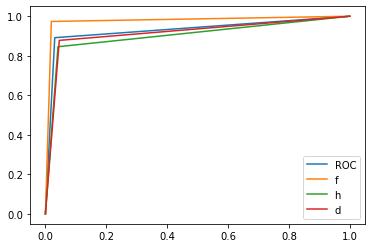

In [334]:
plt.figure()
plt.plot(mnb_fpr[0], mnb_tpr[0], label="ROC")
plt.plot(mnb_fpr[1], mnb_tpr[1], label="f")
plt.plot(mnb_fpr[2], mnb_tpr[2], label="h")
plt.plot(mnb_fpr[3], mnb_tpr[3], label="d")
plt.legend(loc="lower right")
plt.show()

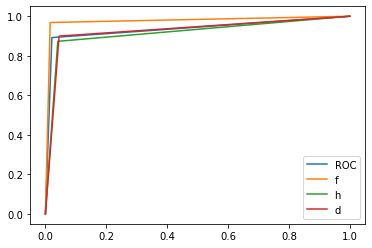

In [335]:
plt.figure()
plt.plot(vnn_fpr[0], vnn_tpr[0], label="ROC")
plt.plot(vnn_fpr[1], vnn_tpr[1], label="f")
plt.plot(vnn_fpr[2], vnn_tpr[2], label="h")
plt.plot(vnn_fpr[3], vnn_tpr[3], label="d")
plt.legend(loc="lower right")
plt.show()

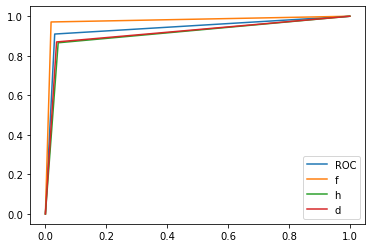

In [336]:
plt.figure()
plt.plot(rnn_fpr[0], rnn_tpr[0], label="ROC")
plt.plot(rnn_fpr[1], rnn_tpr[1], label="f")
plt.plot(rnn_fpr[2], rnn_tpr[2], label="h")
plt.plot(rnn_fpr[3], rnn_tpr[3], label="d")
plt.legend(loc="lower right")
plt.show()

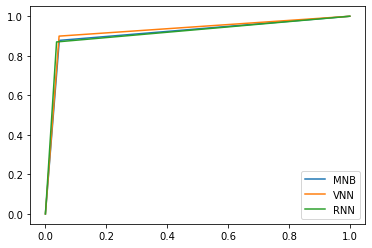

In [333]:
plt.figure()
plt.plot(mnb_fpr[3], mnb_tpr[3], label="MNB")
plt.plot(vnn_fpr[3], vnn_tpr[3], label="VNN")
plt.plot(rnn_fpr[3], rnn_tpr[3], label="RNN")
# plt.plot(mnb_fpr[3], mnb_tpr[3], label="d")
plt.legend(loc="lower right")
plt.show()

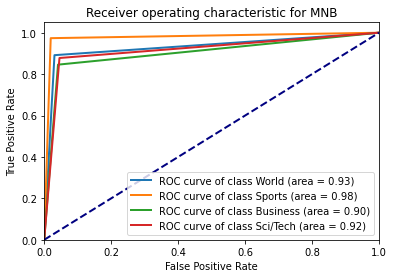

In [364]:
lw = 2
for i in range(4):
    plt.plot(
        mnb_fpr[i],
        mnb_tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], mnb_roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for MNB")
plt.legend(loc="lower right")
plt.savefig('mnb_roc.jpg')
plt.show()

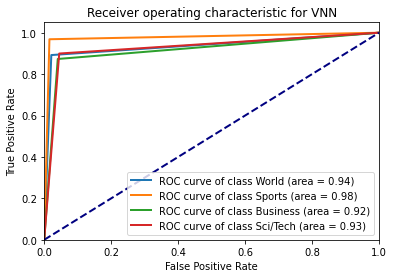

In [365]:
lw = 2
for i in range(4):
    plt.plot(
        vnn_fpr[i],
        vnn_tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], vnn_roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for VNN")
plt.legend(loc="lower right")
plt.savefig('vnn_roc.jpg')
plt.show()

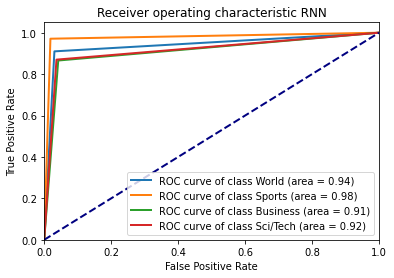

In [366]:
lw = 2
for i in range(4):
    plt.plot(
        rnn_fpr[i],
        rnn_tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], rnn_roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic RNN")
plt.legend(loc="lower right")
plt.savefig('rnn_roc.jpg')
plt.show()

### Confusion matrix

In [352]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = {}

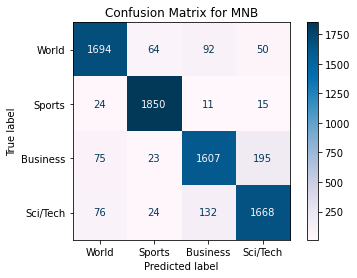

In [362]:
cm['mnb'] = confusion_matrix(y_test, mnb_preds['test'])
cmdisplay = ConfusionMatrixDisplay(cm['mnb'], display_labels=classes)
cmdisplay.plot(cmap='PuBu')
plt.title("Confusion Matrix for MNB")
plt.savefig("mnb_cm")

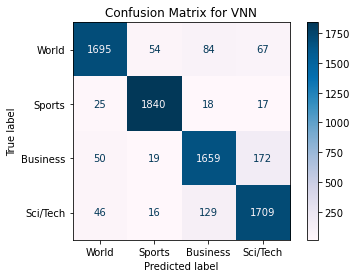

In [361]:
cm['vnn'] = confusion_matrix(y_test, vnn_preds['test'])
cmdisplay = ConfusionMatrixDisplay(cm['vnn'], display_labels=classes)
cmdisplay.plot(cmap='PuBu',)
plt.title("Confusion Matrix for VNN")
plt.savefig("vnn_cm")

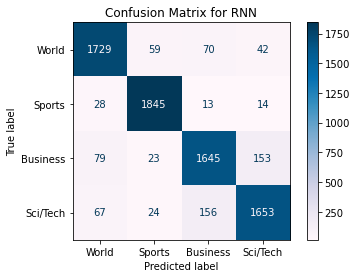

In [363]:
cm['rnn'] = confusion_matrix(y_test, rnn_preds['test'])
cmdisplay = ConfusionMatrixDisplay(cm['rnn'], display_labels=classes)
cmdisplay.plot(cmap='PuBu',)
plt.title("Confusion Matrix for RNN")
plt.savefig("rnn_cm")